In [1]:
import h5py
import glob
import os
import sys
import sympy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, accuracy_score, r2_score
from tensorflow.keras.regularizers import Regularizer
from tensorflow.keras.initializers import Zeros, RandomNormal
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from sklearn.metrics import roc_curve, auc
import tensorflow.keras.backend as K
import qkeras
from qkeras import *

np.random.seed(42)
tf.random.set_seed(42)

In [7]:
X_train = np.load('X_train.npy', mmap_mode='r')
X_val = np.load('X_val.npy', mmap_mode='r')
X_test = np.load('X_test.npy', mmap_mode='r')
Y_train = np.load('Y_train.npy', mmap_mode='r')
Y_val = np.load('Y_val.npy', mmap_mode='r')
Y_test = np.load('Y_test.npy', mmap_mode='r')
pt_truth_test = np.load('pt_truth_test.npy', mmap_mode='r')

print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('Y_val   shape: ' + str(Y_val.shape))
print('Y_test  shape: ' + str(Y_test.shape))
print('pt_truth_test  shape: ' + str(pt_truth_test.shape))

X_train shape: (366839, 14)
X_val   shape: (30570, 14)
X_test  shape: (7602073, 14)
Y_train shape: (366839, 3)
Y_val   shape: (30570, 3)
Y_test  shape: (7602073, 3)
pt_truth_test  shape: (7602073,)


In [ ]:
Y_train = (Y_train[:, 2] == 1).astype(float).reshape(-1, 1)
Y_val = (Y_val[:, 2] == 1).astype(float).reshape(-1, 1)
Y_test = (Y_test[:, 2] == 1).astype(float).reshape(-1, 1)

## read data

In [2]:
data_files = sorted(glob.glob('recon3D/recon3D_d*.parquet'))
labels_files = sorted(glob.glob('labels/labels_d*.parquet'))

chunk_size = 10
data_chunks = []
labels_chunks = []
n_files = 0

#for i in range(0, len(data_files), chunk_size):
for i in range(0, 100, chunk_size):
    data_chunk_files = data_files[i:i+chunk_size]
    labels_chunk_files = labels_files[i:i+chunk_size]
    
    data_chunk_list = []
    labels_chunk_list = []
    
    for rf, lf in zip(data_chunk_files, labels_chunk_files):
        d = pd.read_parquet(rf)
        l = pd.read_parquet(lf)
        
        data_chunk_list.append(d)
        labels_chunk_list.append(l[['y-local', 'pt']])
        
        n_files += 1
        print(f"Processed {n_files} files", end='\r')
        sys.stdout.flush()
    
    chunk_data_df = pd.concat(data_chunk_list, ignore_index=True)
    chunk_labels_df = pd.concat(labels_chunk_list, ignore_index=True)
    
    data_chunks.append(np.reshape(chunk_data_df.to_numpy(), (-1, 20, 13, 21)))
    labels_chunks.append(chunk_labels_df)

del data_chunk_list, labels_chunk_list, d, l, chunk_data_df, chunk_labels_df

## plot data

In [3]:
n = 5
data = np.concatenate(data_chunks[:n], axis=0)
labels = pd.concat(labels_chunks[:n], ignore_index=True)

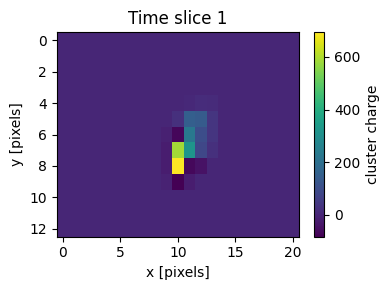

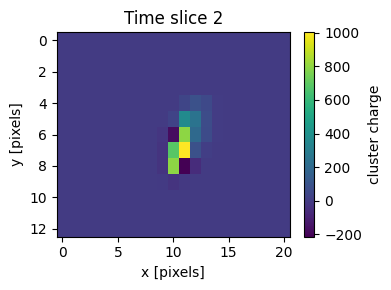

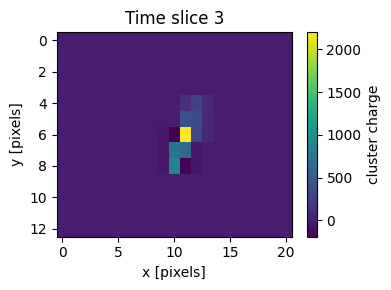

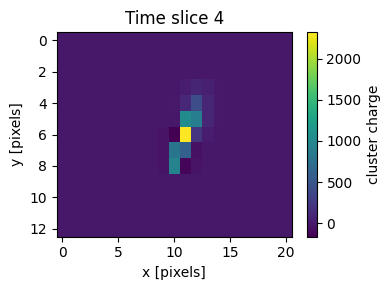

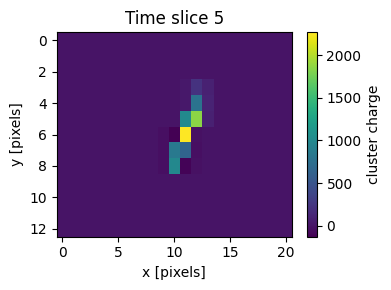

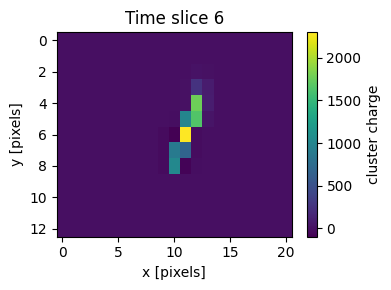

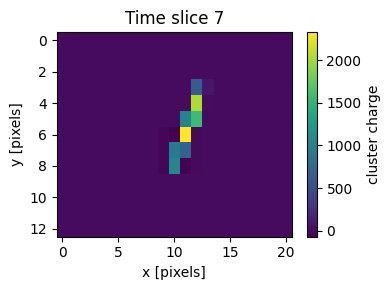

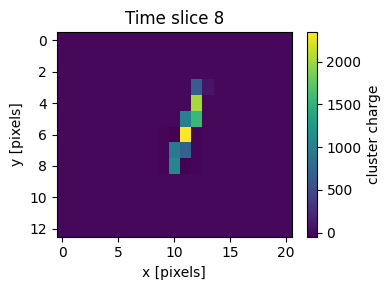

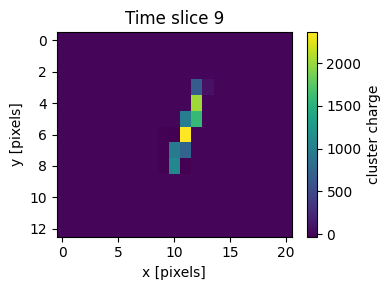

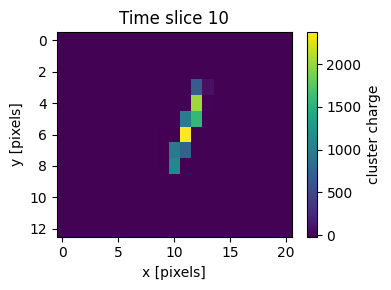

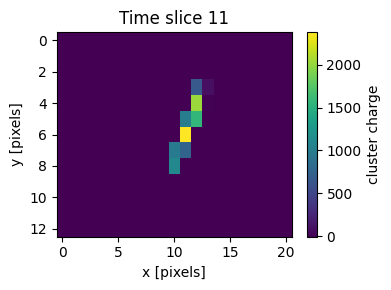

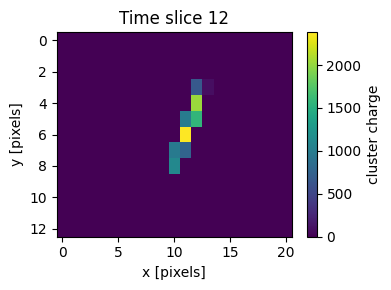

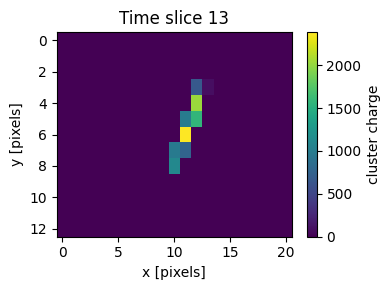

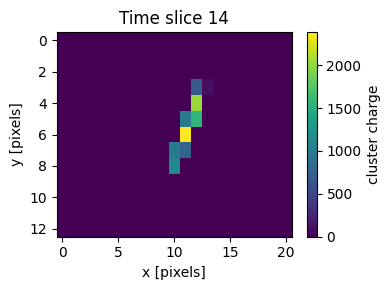

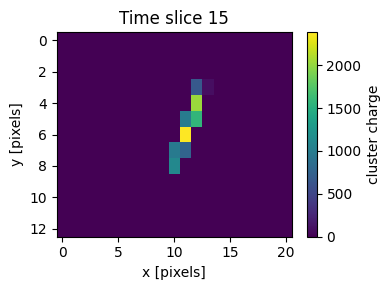

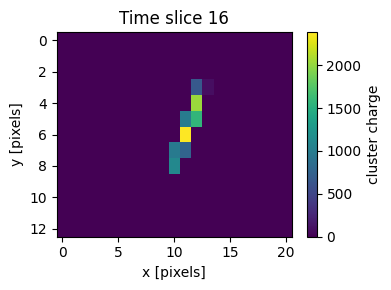

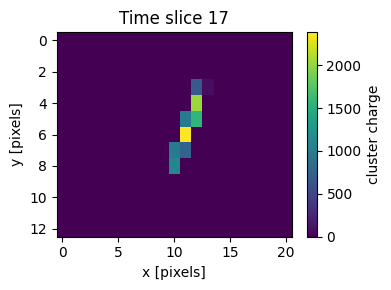

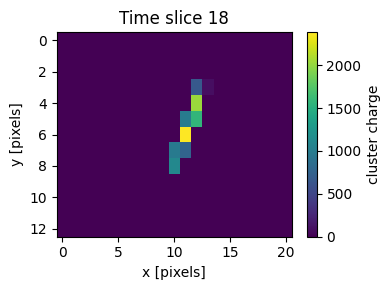

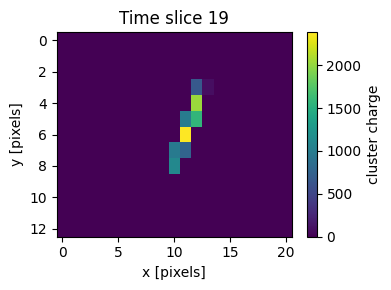

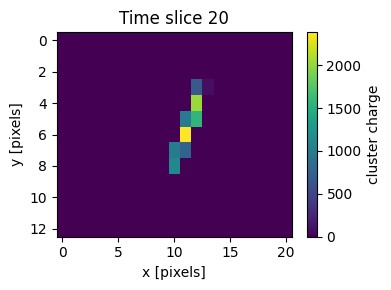

In [4]:
for i in range(data[0].shape[0]):
    plt.figure(figsize=(4, 3))
    plt.imshow(data[0][i], aspect='auto', cmap='viridis')
    plt.title(f'Time slice {i+1}')
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    plt.colorbar(label='cluster charge')
    plt.tight_layout()
    plt.show()

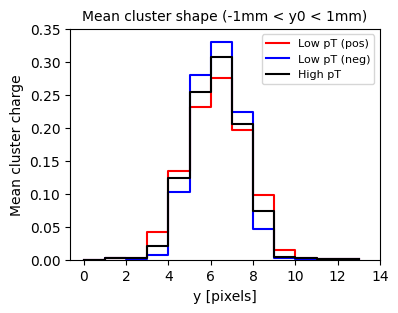

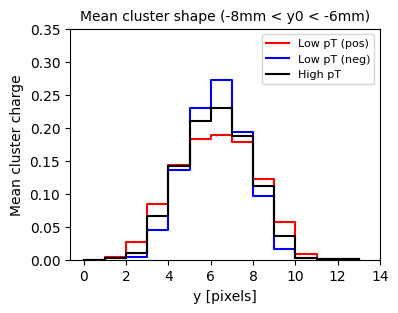

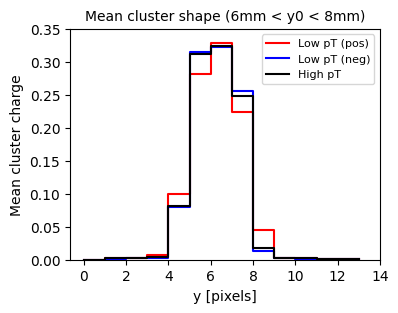

In [5]:
y0_range = [(-1, 1), (-8, -6), (6, 8)]
for r in y0_range:
    data_y0range = data[(labels['y-local'] > r[0]) & (labels['y-local'] < r[1])]
    labels_y0range = labels[(labels['y-local'] > r[0]) & (labels['y-local'] < r[1])]
    
    # take the last time slice, and sum over x to get y profile
    y_profile = data_y0range[:, -1, :, :].sum(axis = -1)
    
    y_profile_low_pos = y_profile[(labels_y0range['pt'] < 0.2) & (labels_y0range['pt'] > 0)]
    y_profile_low_neg = y_profile[(labels_y0range['pt'] > -0.2) & (labels_y0range['pt'] < 0)]
    y_profile_high = y_profile[(labels_y0range['pt'] > 0.2) | (labels_y0range['pt'] < -0.2)]
    
    y_profile_low_pos_mean = y_profile_low_pos.mean(axis = 0)
    y_profile_low_neg_mean = y_profile_low_neg.mean(axis = 0)
    y_profile_high_mean = y_profile_high.mean(axis = 0)
    
    edges = np.arange(len(y_profile_low_pos_mean) + 1)
    
    y_profile_low_pos_mean = np.concatenate(([0], y_profile_low_pos_mean))
    y_profile_low_neg_mean = np.concatenate(([0], y_profile_low_neg_mean))
    y_profile_high_mean = np.concatenate(([0], y_profile_high_mean))
    
    plt.figure(figsize=(4, 3))
    plt.step(edges, y_profile_low_pos_mean/np.sum(y_profile_low_pos_mean), where='post', label = 'Low pT (pos)', color='red')
    plt.step(edges, y_profile_low_neg_mean/np.sum(y_profile_low_neg_mean), where='post', label = 'Low pT (neg)', color='blue')
    plt.step(edges, y_profile_high_mean/np.sum(y_profile_high_mean), where='post', label = 'High pT', color='black')
    plt.title(f"Mean cluster shape ({r[0]}mm < y0 < {r[1]}mm)", size=10)
    #plt.ylim(0, max(y_profile_low_neg_mean)*1.25)
    plt.ylim(0, 0.35)
    plt.xlabel("y [pixels]")
    plt.ylabel("Mean cluster charge")
    plt.xticks(np.arange(0, len(y_profile_low_pos_mean) + 1, 2))
    plt.legend(fontsize=8)
    plt.show()

In [6]:
del data, labels

## prepare training data

In [ ]:
for i in range(len(data_chunks)):
    data_chunks[i] = data_chunks[i][:, -1, :, :].sum(axis = -1)

n = 16
data = np.concatenate(data_chunks[:n], axis=0)
del data_chunks
labels = pd.concat(labels_chunks[:n], ignore_index=True)
del labels_chunks

In [ ]:
X = np.hstack((labels['y-local'].to_numpy().reshape(-1, 1), data))
del data

pt_truth = labels['pt'].to_numpy()
del labels

Y = np.zeros((pt_truth.size, 3))
Y[:, 2] = 1
Y[np.where((pt_truth >= 0) & (pt_truth < 0.2))] = [1, 0, 0]
Y[np.where((pt_truth < 0) & (pt_truth > -0.2))] = [0, 1, 0]

print(X.shape)
print(Y.shape)
print(np.sum(Y, axis=0))
print(pt_truth.shape)

In [ ]:
class0_idx = np.where(Y[:, 0] == 1)[0]
class1_idx = np.where(Y[:, 1] == 1)[0]
class2_idx = np.where(Y[:, 2] == 1)[0]

min_count = min(len(class0_idx), len(class1_idx), len(class2_idx))

chosen_class0 = np.random.choice(class0_idx, min_count, replace=False)
chosen_class1 = np.random.choice(class1_idx, min_count, replace=False)
chosen_class2 = np.random.choice(class2_idx, min_count, replace=False)

balanced_idx = np.concatenate([chosen_class0, chosen_class1, chosen_class2])

np.random.shuffle(balanced_idx)

X_balanced = X[balanced_idx]
Y_balanced = Y[balanced_idx]
pt_truth_balanced = pt_truth[balanced_idx]

all_indices = np.arange(Y.shape[0])
rest_idx = np.setdiff1d(all_indices, balanced_idx)

X_rest = X[rest_idx]
Y_rest = Y[rest_idx]
pt_truth_rest = pt_truth[rest_idx]

del X, Y, pt_truth

print(X_balanced.shape)
print(Y_balanced.shape)
print(np.sum(Y_balanced, axis=0))
print(pt_truth_balanced.shape)

print(X_rest.shape)
print(Y_rest.shape)
print(np.sum(Y_rest, axis=0))
print(pt_truth_rest.shape)

In [ ]:
train_ratio = 0.6
val_ratio = 0.05
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_balanced, Y_balanced, test_size = test_ratio, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 42)

pt_truth_train_val, pt_truth_test = train_test_split(pt_truth_balanced, test_size = test_ratio, random_state = 42)

X_test = np.concatenate((X_test, X_rest), axis=0)
Y_test = np.concatenate((Y_test, Y_rest), axis=0)
pt_truth_test = np.concatenate((pt_truth_test, pt_truth_rest), axis=0)

print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('Y_val   shape: ' + str(Y_val.shape))
print('Y_test  shape: ' + str(Y_test.shape))
print('pt_truth_test  shape: ' + str(pt_truth_test.shape))

del X_balanced, Y_balanced, pt_truth_balanced, X_rest, Y_rest, pt_truth_rest, X_train_val, Y_train_val, pt_truth_train_val

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('X_test.npy', X_test)
np.save('Y_train.npy', Y_train)
np.save('Y_val.npy', Y_val)
np.save('Y_test.npy', Y_test)
np.save('pt_truth_test.npy', pt_truth_test)

## nn model

In [8]:
quantizer = quantized_bits(6, 0, alpha=1)
quantized_relu = 'quantized_relu(6, 0)'

x_input = keras.Input(shape=(14,), name='input')

x = QDense(128, use_bias=True, name='dense1', kernel_quantizer=quantizer, bias_quantizer=quantizer)(x_input)
x = QActivation(quantized_relu, name='relu1')(x)
    
x = QDense(3, use_bias=True, name='dense2', kernel_quantizer=quantizer, bias_quantizer=quantizer)(x)
x = layers.Softmax(name='softmax')(x)
#x = layers.Activation('sigmoid')(x)

model = keras.Model(x_input, x, name='model')

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
#              loss='binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 14)]              0         
                                                                 
 dense1 (QDense)             (None, 128)               1920      
                                                                 
 relu1 (QActivation)         (None, 128)               0         
                                                                 
 dense2 (QDense)             (None, 3)                 387       
                                                                 
 softmax (Softmax)           (None, 3)                 0         
                                                                 
Total params: 2307 (9.01 KB)
Trainable params: 2307 (9.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    epochs=60, batch_size=128)

Epoch 1/60
2866/2866 [==============================] - 2s 628us/step - loss: 0.7484 - accuracy: 0.6706 - val_loss: 0.6553 - val_accuracy: 0.7216
Epoch 2/60
2866/2866 [==============================] - 2s 602us/step - loss: 0.6267 - accuracy: 0.7330 - val_loss: 0.6164 - val_accuracy: 0.7360
Epoch 3/60
2866/2866 [==============================] - 2s 585us/step - loss: 0.6005 - accuracy: 0.7439 - val_loss: 0.5960 - val_accuracy: 0.7436
Epoch 4/60
2866/2866 [==============================] - 2s 553us/step - loss: 0.5877 - accuracy: 0.7492 - val_loss: 0.5859 - val_accuracy: 0.7504
Epoch 5/60
2866/2866 [==============================] - 2s 553us/step - loss: 0.5796 - accuracy: 0.7517 - val_loss: 0.5837 - val_accuracy: 0.7479
Epoch 6/60
2866/2866 [==============================] - 2s 602us/step - loss: 0.5743 - accuracy: 0.7537 - val_loss: 0.5797 - val_accuracy: 0.7486
Epoch 7/60
2866/2866 [==============================] - 2s 595us/step - loss: 0.5704 - accuracy: 0.7554 - val_loss: 0.5749 -

Text(0, 0.5, 'Loss')

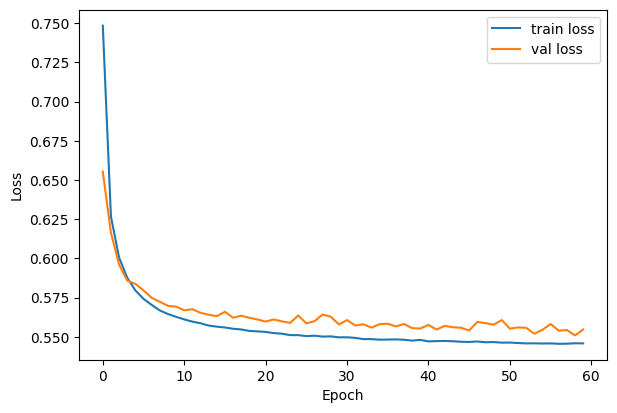

In [10]:
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

In [11]:
Y_nn_pred = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_nn_pred, axis=1))))

237565/237565 [==============================] - 57s 240us/step
Accuracy: 0.6307183580057703


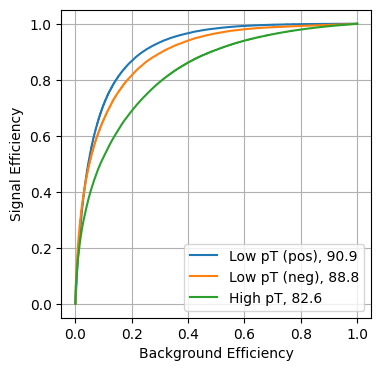

In [12]:
def plot_roc(y_test, y_pred, labels):
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0}, {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='-')
    #plt.semilogy()
    #plt.semilogx()
    plt.ylabel("Signal Efficiency")
    plt.xlabel("Background Efficiency")
    #plt.ylim(0.00001, 1)
    #plt.xlim(0.00001, 1)
    plt.grid(True)
    plt.legend(loc='best', fontsize=10)  
    
plt.figure(figsize=(4, 4))
plot_roc(Y_test, Y_nn_pred, ['Low pT (pos)','Low pT (neg)','High pT'])
#plot_roc(Y_test, Y_nn_pred, [' '])

/var/folders/k_/3rw365c56w9f02q8nb4v2r4r0000gn/T/ipykernel_49831/298819947.py:9: RuntimeWarning: invalid value encountered in divide
  proportions_nn = class_001_counts_nn / total_counts_nn


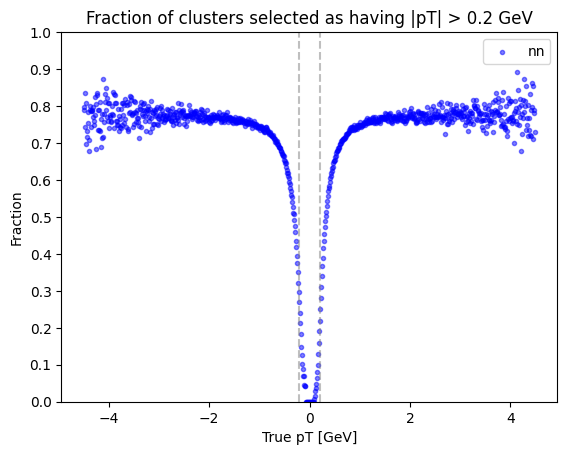

In [24]:
custom_bins = np.arange(-4.5, 4.5, 0.01)
bin_centers = 0.5 * (custom_bins[:-1] + custom_bins[1:])

indices_001_nn = np.argmax(Y_nn_pred, axis=1) == 2

total_counts_nn, _ = np.histogram(pt_truth_test, bins=custom_bins)
class_001_counts_nn, _ = np.histogram(pt_truth_test[indices_001_nn], bins=custom_bins)

proportions_nn = class_001_counts_nn / total_counts_nn
proportions_nn = np.nan_to_num(proportions_nn)

plt.scatter(bin_centers, proportions_nn, marker='.', label='nn', alpha=0.5, color='blue')
plt.axvline(x=0.2, color='grey', linestyle='--', alpha=0.5)
plt.axvline(x=-0.2, color='grey', linestyle='--', alpha=0.5)

plt.legend(fontsize=10)
plt.xlabel('True pT [GeV]')
plt.ylabel('Fraction')
plt.title('Fraction of clusters selected as having |pT| > 0.2 GeV')
plt.yticks(np.arange(0, 1.1, 0.1))
#plt.yscale('log')
plt.ylim(0, 1)
plt.legend()
plt.show()

## symbolnet model

In [13]:
def math_operation(tf_or_sympy, operator, x, y=None):
    # unary operators
    if operator == 'identity':
        output = x
    elif operator == 'sin':
        output = tf.sin(x) if tf_or_sympy == 'tf' else sympy.sin(x)
    elif operator == 'cos':
        output = tf.cos(x) if tf_or_sympy == 'tf' else sympy.cos(x)
    elif operator == 'exp':
        output = tf.exp(x) if tf_or_sympy == 'tf' else sympy.exp(x)
    elif operator == 'gauss':
        output = tf.exp(-x**2) if tf_or_sympy == 'tf' else sympy.exp(-x**2)
    elif operator == 'sinh':
        output = tf.sinh(x) if tf_or_sympy == 'tf' else sympy.sinh(x)
    elif operator == 'cosh':
        output = tf.cosh(x) if tf_or_sympy == 'tf' else sympy.cosh(x)
    elif operator == 'tanh':
        output = tf.tanh(x) if tf_or_sympy == 'tf' else sympy.tanh(x)
    elif operator == 'square':
        output = x**2 if tf_or_sympy == 'tf' else x**2
    elif operator == 'cube':
        output = x**3 if tf_or_sympy == 'tf' else x**3
    elif operator == 'log':
        output = tf.math.log(0.001 + tf.abs(x)) if tf_or_sympy == 'tf' else sympy.log(0.001 + sympy.Abs(x))
        #output = tf.math.log(tf.abs(x)) if tf_or_sympy == 'tf' else sympy.log(sympy.Abs(x))
    # binary operators
    elif operator == '+':
        output = x + y
    elif operator == '*':
        output = x * y
    elif operator == 'pow':
        output = x ** y
    elif operator == '/':
        output = x / (0.001 + tf.abs(y)) if tf_or_sympy == 'tf' else x / (0.001 + sympy.Abs(y))
        #output = x / y
    
    return output

In [26]:
# step function for masking in the forward pass
# custom grad is an estimator of derivative of the step function to avoid vanishing gradient
@tf.custom_gradient
def step_func(x):
    func = tf.where(x > 0., 1., 0.)
    def grad(upstream):
        a = 5.
        return upstream * a * tf.exp(-a*x) / (1 + tf.exp(-a*x))**2
    return func, grad

# dynamic pruning of input features
# define one auxiliary weight and one untrainable threshold per input feature
class Input_sparsity(Layer):
    def __init__(self):
        super().__init__()
        
    def build(self, input_shape):
        # auxiliary weight is untrainable and fixed at 1
        self.aux_w = self.add_weight(name='weight',
                                     shape=(input_shape[-1],),
                                     initializer='ones',
                                     trainable=False)
        # threshold is trainable, initialized at 0, and bounded in [0,1]
        self.aux_w_t = self.add_weight(name='threshold',
                                     shape=(input_shape[-1],),
                                     initializer='zeros',
                                     constraint=lambda x: tf.clip_by_value(x, 0., 1.),
                                     trainable=True)
        
    def call(self, inputs):
        input_masks = step_func(self.aux_w - self.aux_w_t)
        return tf.multiply(inputs, input_masks)

# definition of symbolic layer (usual weights and biases, plus unary/binary operators as activations)
# define trainable thresholds for weights/biases/unary/binary
class Symbolic_Layer(Layer):
    def __init__(self, operators, num_operators):
        super().__init__()
        self.operators = operators
        self.num_operators = num_operators
        self.units = self.num_operators[0] + 2*self.num_operators[1]
        
    def build(self, input_shape):
        # usual model weight w
        self.w = self.add_weight(name='weight',
                                 shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        # usual bias b
        self.b = self.add_weight(name='bias',
                                 shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)
        # auxiliary weight for unary operator, to be used for operator pruning
        # untrainable and fixed at 1
        self.aux_unary = self.add_weight(name='unary',
                                         shape=(self.num_operators[0],),
                                         initializer='ones',
                                         trainable=False)
        # auxiliary weight for binary operator, to be used for operator pruning
        # untrainable and fixed at 1
        if self.num_operators[1] > 0:
            self.aux_binary = self.add_weight(name='binary',
                                              shape=(self.num_operators[1],),
                                              initializer='ones',
                                              trainable=False)
        # threshold for model weight
        # trainable, initialized at 0, unbounded since model weight is unbounded
        self.aux_w_t = self.add_weight(name='weight_threshold',
                                       shape=(input_shape[-1], self.units),
                                       initializer='zeros',
                                       constraint=lambda x: tf.abs(x),
                                       trainable=True)
        # threshold for bias term
        # trainable, initialized at 0, unbounded since model weight is unbounded
        self.aux_b_t = self.add_weight(name='bias_threshold',
                                       shape=(self.units,),
                                       initializer='zeros',
                                       constraint=lambda x: tf.abs(x),
                                       trainable=True)
        # threshold for unary operator
        # trainable, initialized at 0, bounded in [0,1]
        self.aux_unary_t = self.add_weight(name='unary_threshold',
                                          shape=(self.num_operators[0],),
                                          initializer='zeros',
                                          constraint=lambda x: tf.clip_by_value(x, 0., 1.),
                                          trainable=True)
        # threshold for binary operator
        # trainable, initialized at 0, bounded in [0,1]
        if self.num_operators[1] > 0:
            self.aux_binary_t = self.add_weight(name='binary_threshold',
                                                shape=(self.num_operators[1],),
                                                initializer='zeros',
                                                constraint=lambda x: tf.clip_by_value(x, 0., 1.),
                                                trainable=True)

    def call(self, inputs):
        # linear transformation in the forward pass
        # weights and biases are replaced by the step_functioned version
        # so weight is masked whenever its threshold is higher
        w_masks = step_func(tf.abs(self.w) - self.aux_w_t)
        b_masks = step_func(tf.abs(self.b) - self.aux_b_t)
        linear_output = tf.matmul(inputs, tf.multiply(self.w, w_masks)) + tf.multiply(self.b, b_masks)
        
        # activation by unary/binary operator
        symbolic_output = []
        
        # loop over number of unary operators in a symbolic layer
        for i in range(self.num_operators[0]):
            # an unary operator is "pruned" (becomes identity map) whenever the threshold is higher than its auxiliary weight
            unary_mask = step_func(self.aux_unary - self.aux_unary_t)[i]
            idx = np.mod(i, len(self.operators[0]))
            unary_operation = (unary_mask * math_operation('tf',self.operators[0][idx],linear_output[:, i:i+1]) +
                               (1.0 - unary_mask) * math_operation('tf','identity',linear_output[:, i:i+1]))
            symbolic_output.append(unary_operation)
            
        # loop over number of binary operators in a symbolic layer
        for i in range(self.num_operators[0], self.num_operators[0] + 2*self.num_operators[1], 2):
            # a binary operator is "pruned" (becomes addition) whenever the threshold is higher than its auxiliary weight
            j = int((i - self.num_operators[0])/2)
            binary_mask = step_func(self.aux_binary - self.aux_binary_t)[j]
            idx = np.mod(j, len(self.operators[1]))
            binary_operation = (binary_mask * math_operation('tf',self.operators[1][idx],linear_output[:, i:i+1],linear_output[:, i+1:i+2]) +
                                (1.0 - binary_mask) * math_operation('tf','+',linear_output[:, i:i+1],linear_output[:, i+1:i+2]))
            symbolic_output.append(binary_operation)
        
        symbolic_output = tf.concat(symbolic_output, axis=1)
        return symbolic_output
    
def create_model(model_dim, operators, num_operators):
    input_dim, num_hidden_layers, output_dim = model_dim
    layers = []
    
    # input layer
    layers.append(Input(shape=(input_dim,)))
    layers.append(Input_sparsity()(layers[-1]))
    
    # hidden symbolic layers
    for i in range(num_hidden_layers):
        layers.append(Symbolic_Layer(operators=operators[i],
                                     num_operators=num_operators[i])(layers[-1]))
    
    # output layer
    layers.append(Symbolic_Layer(operators=[['identity'], [None]],
                                 num_operators=[output_dim, 0])(layers[-1]))
    
    model = keras.Model(inputs=layers[0], outputs=layers[-1], name='model')
    return model, model_dim, operators, num_operators

input_dim  = X_train.shape[1]
num_hidden = 1
output_dim = Y_train.shape[1]
model_dim = [input_dim, num_hidden, output_dim]

# operator choices per hidden symbolic layer
operators = [
    [['sin','exp','tanh'], ['*']], # 1st symbolic layer [[unary], [binary]]
    #[['sin','exp','tanh'], ['*']], # 2nd ...
            ]

# number of unary and binary operators per hidden symbolic layer
num_operators = [
    [100, 40], # 1st symbolic layer [num_unary, num_binary]
    #[20, 4], # 2nd ...
]

model = create_model(model_dim=model_dim,
                     operators=operators,
                     num_operators=num_operators)
model[0].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14)]              0         
                                                                 
 input_sparsity_1 (Input_sp  (None, 14)                28        
 arsity)                                                         
                                                                 
 symbolic__layer_2 (Symboli  (None, 140)               5680      
 c_Layer)                                                        
                                                                 
 symbolic__layer_3 (Symboli  (None, 3)                 852       
 c_Layer)                                                        
                                                                 
Total params: 6560 (25.62 KB)
Trainable params: 6403 (25.01 KB)
Non-trainable params: 157 (628.00 Byte)
_______________________

In [27]:
class neuralSR(keras.Model):
    def __init__(self, model, alpha_sparsity_input, alpha_sparsity_model, alpha_sparsity_unary, alpha_sparsity_binary):
        super().__init__()
        self.model, self.model_dim, self.operators, self.num_operators = model
        self.alpha_sparsity_input = alpha_sparsity_input
        self.alpha_sparsity_model = alpha_sparsity_model
        self.alpha_sparsity_unary = alpha_sparsity_unary
        self.alpha_sparsity_binary = alpha_sparsity_binary
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.regression_loss_tracker = keras.metrics.Mean(name="regression_loss")
        self.threshold_input_reg_loss_tracker = keras.metrics.Mean(name="threshold_input_reg_loss")
        self.threshold_input_mean_tracker = keras.metrics.Mean(name="threshold_input_mean")
        self.threshold_model_reg_loss_tracker = keras.metrics.Mean(name="threshold_model_reg_loss")
        self.threshold_model_mean_tracker = keras.metrics.Mean(name="threshold_model_mean")
        self.threshold_unary_reg_loss_tracker = keras.metrics.Mean(name="threshold_unary_reg_loss")
        self.threshold_unary_mean_tracker = keras.metrics.Mean(name="threshold_unary_mean")
        self.threshold_binary_reg_loss_tracker = keras.metrics.Mean(name="threshold_binary_reg_loss")
        self.threshold_binary_mean_tracker = keras.metrics.Mean(name="threshold_binary_mean")
        self.weight_input_mean_tracker = keras.metrics.Mean(name="weight_input_mean")
        self.weight_model_mean_tracker = keras.metrics.Mean(name="weight_model_mean")
        self.weight_unary_mean_tracker = keras.metrics.Mean(name="weight_unary_mean")
        self.weight_binary_mean_tracker = keras.metrics.Mean(name="weight_binary_mean")
        self.sparsity_input_tracker = keras.metrics.Mean(name="sparsity_input")
        self.sparsity_model_tracker = keras.metrics.Mean(name="sparsity_model")
        self.sparsity_unary_tracker = keras.metrics.Mean(name="sparsity_unary")
        self.sparsity_binary_tracker = keras.metrics.Mean(name="sparsity_binary")
        self.accuracy_tracker = keras.metrics.Accuracy(name="accuracy")
    
    def get_hyperparameters(self):
        return self.model_dim, self.operators, self.num_operators
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.regression_loss_tracker,
            self.threshold_input_reg_loss_tracker,
            self.threshold_input_mean_tracker,
            self.threshold_model_reg_loss_tracker,
            self.threshold_model_mean_tracker,
            self.threshold_unary_reg_loss_tracker,
            self.threshold_unary_mean_tracker,
            self.threshold_binary_reg_loss_tracker,
            self.threshold_binary_mean_tracker,
            self.weight_input_mean_tracker,
            self.weight_model_mean_tracker,
            self.weight_unary_mean_tracker,
            self.weight_binary_mean_tracker,
            self.sparsity_input_tracker,
            self.sparsity_model_tracker,
            self.sparsity_unary_tracker,
            self.sparsity_binary_tracker,
            self.accuracy_tracker
        ]
    
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self.model(x)
            
            # base training loss (MSE)
            regression_loss = tf.reduce_mean(tf.reduce_sum(tf.cast((y-y_pred)**2,dtype=tf.float64), axis=1))
            
            # the followings calculate sparsity levels at train steps
            # since total loss = MSE + sparsity regularization terms
            # where sparsity regularization terms depend on sparsity levels
            
            # call auxiliary weights and thresholds for inputs
            w_input = self.non_trainable_weights[0]
            w_t_input = self.trainable_weights[0]
            num_input_masks = tf.reduce_sum(tf.cast(tf.where(w_input - w_t_input > 0., 0., 1.), dtype=tf.float64))
            num_input_weights = tf.size(w_input, out_type=tf.float64)
            sparsity_input = num_input_masks/num_input_weights
            weight_input_mean = tf.reduce_sum(tf.cast(tf.abs(w_input),dtype=tf.float64))/num_input_weights
            
            # calculate input sparsity
            t_input_sum = tf.reduce_sum(tf.cast(w_t_input,dtype=tf.float64))
            t_input_dim = num_input_weights
            threshold_input_mean = t_input_sum/t_input_dim
            
            # call model weights and thresholds for all hidden symbolic layers
            # then calculate model weight (weight+bias) sparsity
            num_model_masks = 0.
            num_model_weights = 0.
            weight_model_mean = 0.
            t_model_sum = 0.
            t_model_dim = 0.
            sum_exp_t = 0.
            for i in range(self.model_dim[1]+1):
                w_model = self.trainable_weights[1+6*i]
                b_model = self.trainable_weights[1+6*i+1]
                w_t_model = self.trainable_weights[1+6*i+2]
                b_t_model = self.trainable_weights[1+6*i+3]
                sum_exp_t += tf.reduce_sum(tf.exp(-tf.cast(w_t_model,dtype=tf.float64)))
                sum_exp_t += tf.reduce_sum(tf.exp(-tf.cast(b_t_model,dtype=tf.float64)))
                num_model_masks += tf.reduce_sum(tf.cast(tf.where(-w_t_model + tf.abs(w_model) > 0., 0., 1.),dtype=tf.float64))
                num_model_masks += tf.reduce_sum(tf.cast(tf.where(-b_t_model + tf.abs(b_model) > 0., 0., 1.),dtype=tf.float64))
                num_model_weights += tf.size(w_model, out_type=tf.float64)
                num_model_weights += tf.size(b_model, out_type=tf.float64)
                weight_model_mean += tf.reduce_sum(tf.cast(tf.abs(w_model),dtype=tf.float64)) + tf.reduce_sum(tf.cast(tf.abs(b_model),dtype=tf.float64))
                t_model_dim += tf.size(w_t_model, out_type=tf.float64) + tf.size(b_t_model, out_type=tf.float64)
                t_model_sum += tf.reduce_sum(tf.cast(w_t_model,dtype=tf.float64)) + tf.reduce_sum(tf.cast(b_t_model,dtype=tf.float64))
            sparsity_model = num_model_masks/num_model_weights
            weight_model_mean = weight_model_mean/num_model_weights

            threshold_model_mean = t_model_sum/t_model_dim
            
            # call auxiliary weights and thresholds for unary and binary operators
            num_unary_masks = 0.
            num_unary_weights = 0.
            weight_unary_mean = 0.
            num_binary_masks = 0.
            num_binary_weights = 0.
            weight_binary_mean = 0.
            t_u_sum = 0.
            t_u_dim = 0.
            t_b_sum = 0.
            t_b_dim = 0.
            for i in range(self.model_dim[1]):
                u = self.non_trainable_weights[2*i+1]
                u_t = self.trainable_weights[1+6*i+4]
                num_unary_masks += tf.reduce_sum(tf.cast(tf.where(u - u_t > 0., 0., 1.),dtype=tf.float64))
                num_unary_weights += tf.size(u, out_type=tf.float64)
                weight_unary_mean += tf.reduce_sum(tf.cast(u,dtype=tf.float64))
                t_u_dim += tf.size(u_t, out_type=tf.float64)
                t_u_sum += tf.reduce_sum(tf.cast(u_t,dtype=tf.float64))
                
                b = self.non_trainable_weights[2*i+2]
                b_t = self.trainable_weights[1+6*i+5]
                num_binary_masks += tf.reduce_sum(tf.cast(tf.where(b - b_t > 0., 0., 1.),dtype=tf.float64))
                num_binary_weights += tf.size(b, out_type=tf.float64)
                weight_binary_mean += tf.reduce_sum(tf.cast(b,dtype=tf.float64))
                t_b_dim += tf.size(b_t, out_type=tf.float64)
                t_b_sum += tf.reduce_sum(tf.cast(b_t,dtype=tf.float64))
                    
            # calculate sparsity levels for unary and binary operators
            sparsity_unary = num_unary_masks/num_unary_weights
            sparsity_binary = num_binary_masks/num_binary_weights
            weight_unary_mean = weight_unary_mean/num_unary_weights
            weight_binary_mean = weight_binary_mean/num_binary_weights
            
            threshold_unary_mean = t_u_sum/t_u_dim
            threshold_binary_mean = t_b_sum/t_b_dim
            
            # sparsity regularization terms
            threshold_input_reg_loss = regression_loss*tf.exp(-threshold_input_mean)
            threshold_model_reg_loss = regression_loss*sum_exp_t/num_model_weights
            threshold_unary_reg_loss = regression_loss*tf.exp(-threshold_unary_mean)
            threshold_binary_reg_loss = regression_loss*tf.exp(-threshold_binary_mean)
            # additional decay factor
            def reg(s, s_t, d):
                return tf.exp(-(s_t/(s_t-tf.minimum(s, s_t)))**d+1.)
            threshold_input_reg_loss *= reg(sparsity_input, self.alpha_sparsity_input, 0.01)
            threshold_model_reg_loss *= reg(sparsity_model, self.alpha_sparsity_model, 0.01)
            threshold_unary_reg_loss *= reg(sparsity_unary, self.alpha_sparsity_unary, 0.01)
            threshold_binary_reg_loss *= reg(sparsity_binary, self.alpha_sparsity_binary, 0.01)
            
            # total loss
            total_loss = regression_loss + (threshold_model_reg_loss + 
                                            threshold_input_reg_loss + 
                                            threshold_unary_reg_loss +
                                            threshold_binary_reg_loss)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
                
        self.total_loss_tracker.update_state(total_loss)
        self.regression_loss_tracker.update_state(regression_loss)
        self.threshold_input_reg_loss_tracker.update_state(threshold_input_reg_loss)
        self.threshold_input_mean_tracker.update_state(threshold_input_mean)
        self.threshold_model_reg_loss_tracker.update_state(threshold_model_reg_loss)
        self.threshold_model_mean_tracker.update_state(threshold_model_mean)
        self.threshold_unary_reg_loss_tracker.update_state(threshold_unary_reg_loss)
        self.threshold_unary_mean_tracker.update_state(threshold_unary_mean)
        self.threshold_binary_reg_loss_tracker.update_state(threshold_binary_reg_loss)
        self.threshold_binary_mean_tracker.update_state(threshold_binary_mean)
        self.weight_model_mean_tracker.update_state(weight_model_mean)
        self.weight_input_mean_tracker.update_state(weight_input_mean)
        self.weight_unary_mean_tracker.update_state(weight_unary_mean)
        self.weight_binary_mean_tracker.update_state(weight_binary_mean)
        self.accuracy_tracker.update_state(tf.argmax(y, axis=1), tf.argmax(y_pred, axis=1))
        self.sparsity_input_tracker.update_state(sparsity_input)
        self.sparsity_model_tracker.update_state(sparsity_model)
        self.sparsity_unary_tracker.update_state(sparsity_unary)
        self.sparsity_binary_tracker.update_state(sparsity_binary)
        return {
            'loss': self.total_loss_tracker.result(),
            'regression_loss': self.regression_loss_tracker.result(),
            'threshold_input_reg_loss': self.threshold_input_reg_loss_tracker.result(),
            'threshold_input_mean': self.threshold_input_mean_tracker.result(),
            'threshold_model_reg_loss': self.threshold_model_reg_loss_tracker.result(),
            'threshold_model_mean': self.threshold_model_mean_tracker.result(),
            'threshold_unary_reg_loss': self.threshold_unary_reg_loss_tracker.result(),
            'threshold_unary_mean': self.threshold_unary_mean_tracker.result(),
            'threshold_binary_reg_loss': self.threshold_binary_reg_loss_tracker.result(),
            'threshold_binary_mean': self.threshold_binary_mean_tracker.result(),
            'weight_model_mean': self.weight_model_mean_tracker.result(),
            #'weight_input_mean': self.weight_input_mean_tracker.result(),
            #'weight_unary_mean': self.weight_unary_mean_tracker.result(),
            #'weight_binary_mean': self.weight_binary_mean_tracker.result(),
            'sparsity_input': self.sparsity_input_tracker.result(),
            'sparsity_model': self.sparsity_model_tracker.result(),
            'sparsity_unary': self.sparsity_unary_tracker.result(),
            'sparsity_binary': self.sparsity_binary_tracker.result(),
            'accuracy': self.accuracy_tracker.result(),
        }

In [28]:
nsr = neuralSR(model,
               # set target sparsity level per pruning type
               alpha_sparsity_input=0.1,
               alpha_sparsity_model=0.5,
               alpha_sparsity_unary=0.2,
               alpha_sparsity_binary=0.2)
nsr.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [29]:
h = nsr.fit(X_train, Y_train, epochs=14, batch_size=128)
history = dict()
for key in h.history.keys():
    values = []
    values += h.history[key]
    history[key] = values

Epoch 1/14
2866/2866 [==============================] - 24s 6ms/step - loss: 11.4316 - regression_loss: 2.3810 - threshold_input_reg_loss: 2.0017 - threshold_input_mean: 0.1749 - threshold_model_reg_loss: 0.1146 - threshold_model_mean: 0.0429 - threshold_unary_reg_loss: 1.9737 - threshold_unary_mean: 0.1891 - threshold_binary_reg_loss: 1.9535 - threshold_binary_mean: 0.1990 - weight_model_mean: 0.0452 - sparsity_input: 0.0000e+00 - sparsity_model: 0.5848 - sparsity_unary: 0.0000e+00 - sparsity_binary: 0.0000e+00 - accuracy: 0.5268
Epoch 2/14
2866/2866 [==============================] - 17s 6ms/step - loss: 3.5328 - regression_loss: 1.0136 - threshold_input_reg_loss: 0.7981 - threshold_input_mean: 0.2483 - threshold_model_reg_loss: 0.0000e+00 - threshold_model_mean: 0.0552 - threshold_unary_reg_loss: 0.7824 - threshold_unary_mean: 0.2688 - threshold_binary_reg_loss: 0.7715 - threshold_binary_mean: 0.2836 - weight_model_mean: 0.0502 - sparsity_input: 0.0000e+00 - sparsity_model: 0.6762 -

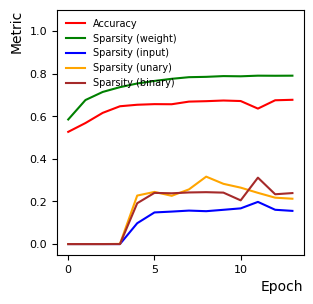

In [30]:
size_axis_title=10
size_axis_label=8
size_legend=7
plt.figure(figsize = (7,7))
axes = plt.subplot(2,2,1)
axes.set_ylim([-0.05,1.1])
plt.xticks(fontsize = size_axis_label) 
plt.yticks(fontsize = size_axis_label) 
axes.plot(history['accuracy'], label='Accuracy', linestyle='solid', c='r')
axes.plot(history['sparsity_model'], label='Sparsity (weight)', linestyle='solid', c='g')
axes.plot(history['sparsity_input'], label='Sparsity (input)', linestyle='solid', c='b')
axes.plot(history['sparsity_unary'], label='Sparsity (unary)', linestyle='solid', c='orange')
axes.plot(history['sparsity_binary'], label='Sparsity (binary)', linestyle='solid', c='brown')
axes.set_xlabel('Epoch', size=size_axis_title, loc='right')
axes.set_ylabel('Metric', size=size_axis_title, loc='top')
axes.legend(loc = 'best', frameon = False, fontsize = size_legend)
plt.show()

In [31]:
Y_sr_pred = nsr.model.predict(X_test)
print("Accuracy = {}".format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_sr_pred, axis=1))))

237565/237565 [==============================] - 190s 798us/step
Accuracy = 0.20284217212857597


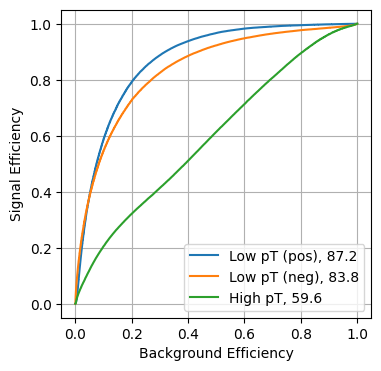

In [32]:
def plot_roc(y_test, y_pred, labels):
    for x, label in enumerate(labels):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0}, {1:.1f}'.format(label, auc(fpr, tpr)*100.), linestyle='-')
    #plt.semilogy()
    #plt.semilogx()
    plt.ylabel("Signal Efficiency")
    plt.xlabel("Background Efficiency")
    #plt.ylim(0.00001, 1)
    #plt.xlim(0.00001, 1)
    plt.grid(True)
    plt.legend(loc='best', fontsize=10)  
    
plt.figure(figsize=(4, 4))
plot_roc(Y_test, Y_sr_pred, ['Low pT (pos)','Low pT (neg)','High pT'])
#plot_roc(Y_test, Y_sr_pred, [' '])

/var/folders/k_/3rw365c56w9f02q8nb4v2r4r0000gn/T/ipykernel_49831/2183663949.py:9: RuntimeWarning: invalid value encountered in divide
  proportions_sr = class_001_counts_sr / total_counts_sr


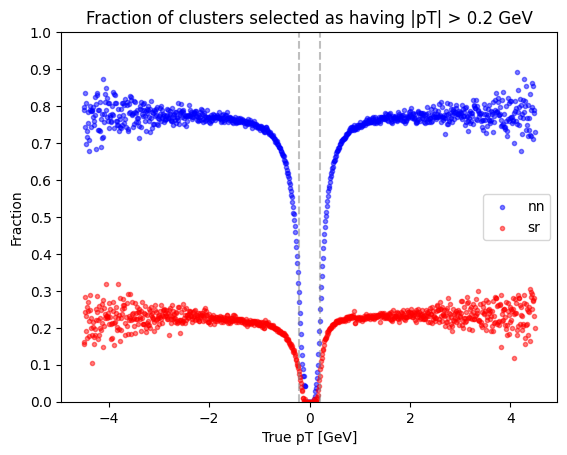

In [33]:
custom_bins = np.arange(-4.5, 4.5, 0.01)
bin_centers = 0.5 * (custom_bins[:-1] + custom_bins[1:])

indices_001_sr = np.argmax(Y_sr_pred, axis=1) == 2

total_counts_sr, _ = np.histogram(pt_truth_test, bins=custom_bins)
class_001_counts_sr, _ = np.histogram(pt_truth_test[indices_001_sr], bins=custom_bins)

proportions_sr = class_001_counts_sr / total_counts_sr
proportions_sr = np.nan_to_num(proportions_sr)

plt.scatter(bin_centers, proportions_nn, marker='.', label='nn', alpha=0.5, color='blue')
plt.scatter(bin_centers, proportions_sr, marker='.', label='sr', alpha=0.5, color='red')
plt.axvline(x=0.2, color='grey', linestyle='--', alpha=0.5)
plt.axvline(x=-0.2, color='grey', linestyle='--', alpha=0.5)

plt.legend(fontsize=10)
plt.xlabel('True pT [GeV]')
plt.ylabel('Fraction')
plt.title('Fraction of clusters selected as having |pT| > 0.2 GeV')
plt.yticks(np.arange(0, 1.1, 0.1))
#plt.yscale('log')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [34]:
# set significant digits for expression display
significant_digits = 2

# use sympy to expand the trained model
def get_expressions(neuralSR):
    model_dim, operators, num_operators = neuralSR.get_hyperparameters()
    input_dim, num_hidden_layers, output_dim = model_dim
    
    x=[]
    for i in range(input_dim):
        x.append(sympy.Symbol('x{}'.format(i)))
    x_masked = sympy.Matrix([x])
    
    w_input = neuralSR.model.layers[1].get_weights()[1]
    t_input = neuralSR.model.layers[1].get_weights()[0]
    num_input_masks = tf.reduce_sum(tf.cast(tf.where(w_input-t_input>0., 0., 1.),dtype=tf.float64))
    num_input_weights = tf.size(w_input, out_type=tf.float64)
    
    sparsity_input = num_input_masks/num_input_weights
    
    w_input_masked = sympy.Matrix(tf.where(w_input-t_input>0., w_input, 0.))
    x_print = np.multiply(sympy.Transpose(w_input_masked), x_masked)
    x_masked = np.multiply(sympy.Transpose(w_input_masked), x_masked)

    print('Remaining Inputs after pruning: {}\n'.format(str(x_masked).replace('1.0*','')))
    
    num_masks = 0.
    num_weights = 0.
    
    num_unary_masks = 0.
    num_binary_masks = 0.
    num_unary = 0.
    num_binary = 0.
    
    for i in range(num_hidden_layers+1):
        w = neuralSR.model.layers[i+2].get_weights()[0]
        b = neuralSR.model.layers[i+2].get_weights()[1]
        w_t = neuralSR.model.layers[i+2].get_weights()[2]
        b_t = neuralSR.model.layers[i+2].get_weights()[3]
        
        num_masks += tf.reduce_sum(tf.cast(tf.where(tf.abs(w) - w_t > 0., 0., 1.),dtype=tf.float64))
        num_masks += tf.reduce_sum(tf.cast(tf.where(tf.abs(b) - b_t > 0., 0., 1.),dtype=tf.float64))
        num_weights += tf.size(w, out_type=tf.float64)
        num_weights += tf.size(b, out_type=tf.float64)
        
        w_masked = sympy.Matrix(tf.where(tf.abs(w) - w_t > 0., w, 0.))
        b_masked = sympy.Transpose(sympy.Matrix(tf.where(tf.abs(b) - b_t > 0., b, 0.)))
        
        x_masked = (x_masked * w_masked + b_masked).evalf(significant_digits)
        if i < num_hidden_layers:
            unary = neuralSR.model.layers[i+2].get_weights()[6]
            unary_t = neuralSR.model.layers[i+2].get_weights()[4]
            binary = neuralSR.model.layers[i+2].get_weights()[7]
            binary_t = neuralSR.model.layers[i+2].get_weights()[5]
            num_unary_masks += tf.reduce_sum(tf.cast(tf.where(unary - unary_t > 0., 0., 1.),dtype=tf.float64))
            num_binary_masks += tf.reduce_sum(tf.cast(tf.where(binary - binary_t > 0., 0., 1.),dtype=tf.float64))
            num_unary += tf.size(unary, out_type=tf.float64)
            num_binary += tf.size(binary, out_type=tf.float64)
        elif i == num_hidden_layers:
            num_operators.append([output_dim, 0])
            operators.append([['identity'], [None]])
            
        y_masked = sympy.zeros(1, num_operators[i][0] + num_operators[i][1])
        
        unary_mask = sympy.Matrix(tf.where(unary - unary_t > 0., 1., 0.))
        binary_mask = sympy.Matrix(tf.where(binary - binary_t > 0., 1., 0.))
        for j in range(num_operators[i][0]):
            idx = np.mod(j, len(operators[i][0]))
            if i < num_hidden_layers:
                y_masked[0,j] = (unary_mask[j] * math_operation('sympy',operators[i][0][idx],x_masked[0,j]) +
                             (1.0 - unary_mask[j]) * math_operation('sympy','identity',x_masked[0,j]))
            elif i == num_hidden_layers:
                y_masked[0,j] = x_masked[0,j]
        for j in range(num_operators[i][1]):
            idx = np.mod(j, len(operators[i][1]))
            y_masked[0,num_operators[i][0]+j] = (binary_mask[j] * math_operation('sympy',operators[i][1][idx],x_masked[0,num_operators[i][0]+2*j],x_masked[0,num_operators[i][0]+2*j+1]) +
                                              (1.0 - binary_mask[j]) * math_operation('sympy','+',x_masked[0,num_operators[i][0]+2*j],x_masked[0,num_operators[i][0]+2*j+1]))
        x_masked = y_masked.evalf(significant_digits)
    
    sparsity_model = num_masks/num_weights
    sparsity_unary = num_unary_masks/num_unary
    sparsity_binary = num_binary_masks/num_binary
    
    complexity = []
    for j in range(len(x_masked)):
        c = 0
        for tree_node in sympy.preorder_traversal(x_masked[j]):
            c += 1
        complexity.append(c)
    
    return x_masked, complexity, sparsity_input, sparsity_model, sparsity_unary, sparsity_binary
  
expressions_masked, complexity, sparsity_input, sparsity_model, sparsity_unary, sparsity_binary = get_expressions(nsr)
print('Unroll network into symbolic expressions (input sparsity = {0:.3f}; model sparsity = {1:.3f}; unary sparsity = {2:.3f}; binary sparsity = {2:.3f})\n--------------'.format(sparsity_input, sparsity_model, sparsity_unary, sparsity_binary))
print('Mean complexity = {0:.1f}\n--------------'.format(np.mean(complexity)))
for i in range(expressions_masked.shape[1]):
    print('expr_{0} (complexity = {1}):\n\n{2}\n-------------------------------------'.format(i,complexity[i],expressions_masked[i]))

Remaining Inputs after pruning: [[x0 x1 x2 x3 x4 x5 x6 x7 x8 x9 0
  x11 0 0]]

Unroll network into symbolic expressions (input sparsity = 0.214; model sparsity = 0.788; unary sparsity = 0.230; binary sparsity = 0.230)
--------------
Mean complexity = 334.0
--------------
expr_0 (complexity = 437):

0.13*x0 + 0.093*x7*(-0.34*x4 - 0.17*x5 - 0.16*x6 - 0.48) - 0.03*x9 + 0.099*(0.58*x0 - 0.13*x3)*(-0.5*x0 + 0.37*x6 + 0.27*x8) - 0.16*(0.59*x0 + 0.18*x7)*(0.024*x11 + 0.066*x2 - 0.31*x6 + 0.41*x9) + 0.087*(-0.096*x2 - 0.26*x3 - 0.025*x5)*(0.19*x0 - 0.076*x4 + 0.34*x7 + 0.32*x8 + 0.33*x9) + 0.076*(0.089*x2 + 0.29*x5 + 0.39*x8 - 0.34*x9)*(-0.22*x0 + 0.15*x4 - 0.059*x5 + 0.32*x6 - 0.49*x7) - 0.14*exp(-0.19*x11 + 0.11*x7) - 0.21*exp(-0.026*x11 + 0.16*x6) - 0.15*exp(-0.095*x11 - 1.4*x6 + 0.046*x8) - 0.37*sin(0.17*x4) - 0.055*sin(0.53*x1 - 0.19*x11) + 0.081*sin(0.73*x5 + 0.3*x8) + 0.096*sin(0.85*x0 - 0.97*x5 + 0.69*x6 - 1.0*x7 + 0.42) - 0.052*sin(0.18*x1 + 0.19*x11 + 0.14*x2 + 0.12*x3 + 1.5*x4 + 1.6